In [44]:
# import nessecary libraries
import gym
import gym_maze
import time
import random
import numpy
import matplotlib.pyplot as plt

In [45]:
# define directions using numbers
N = 0
E = 1
S = 2
W = 3

In [46]:
# function to show value for each cell
def draw_values(data, cell_width=1, cell_height=1):
    # Prepare data for plotting
    values = [data.get(i, 0) for i in range(100)]

    grid_values = [values[i:i+10] for i in range(0, len(values), 10)]

    # Calculate the total size of the figure
    fig_width = 10 * cell_width
    fig_height = 10 * cell_height

    # Create the plot with specified figure size
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(grid_values, cmap='viridis', interpolation='nearest')

    # Add text annotations with values formatted to 3 decimal places
    for i in range(10):
        for j in range(10):
            plt.text(j, i, '{:.3f}'.format(grid_values[i][j]), ha='center', va='center', color='black')

    # Customize plot aesthetics
    plt.title('Grid Visualization')
    plt.colorbar(label='Values')
    plt.xticks(range(10), range(10))
    plt.yticks(range(10), range(10))
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.grid(visible=False)
    plt.show()

In [47]:
# function to draw value arrows in each cell
def draw_grid(directions, no_arrow_positions = []):
    rows = 10
    columns = 10
    cell_size = 1

    fig, ax = plt.subplots()

    for row in range(rows):
        for col in range(columns):
            index = row * columns + col
            direction = directions.get(index, None)

            if direction is not None and index not in no_arrow_positions:
                x = col * cell_size + cell_size / 2
                y = (rows - 1 - row) * cell_size + cell_size / 2

                if direction == 0:  # Upward arrow
                    ax.arrow(x, y, 0, cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 2:  # Right arrow
                    ax.arrow(x, y, cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 1:  # Downward arrow
                    ax.arrow(x, y, 0, -cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 3:  # Left arrow
                    ax.arrow(x, y, -cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
            elif index in no_arrow_positions:
                c = 'black'
                if index == 47:
                    c = 'green'
                    
                ax.add_patch(plt.Rectangle((col, rows - 1 - row), 1, 1, color=c))

    ax.set_aspect('equal')
    ax.set_xlim(0, columns)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [48]:
def map_state(state):
    return state[1] * ROW + state[0] 

In [49]:
def get_col_row(state):
    return (state % COLUMN, state // COLUMN)

In [50]:
def select_action(Q, s, epsilon = 1):
    if(random.random() < epsilon):
        return random.randint(0, 3)
    else:
        action = 0
        for i in range(4):
            if Q[s][i] > Q[s][action]:
                action = i

        return action

In [51]:
env = gym.make("maze-random-10x10-plus-v0")
# Gets the size of the maze
COLUMN, ROW = env.maze_size
CELLS = COLUMN * ROW

In [52]:
class Agent():
    def __init__(
        self,
        env,
        NUM_TRAIN_STEP = (1000000, 1000000),
        NUM_TEST_STEP = (100000, 100000),
        alpha = (0.09, 0.09),
        gamma = (0.99,0.99)
    ):
        self.env = env
        self.NUM_TRAIN_STEP = NUM_TRAIN_STEP
        self.NUM_TEST_STEP = NUM_TEST_STEP
        
        self.alpha = alpha
        self.gamma = gamma

    def select_action(self, Q, s, epsilon):
        if(random.random() < epsilon):
            return random.randint(0, 3)
        else:
            action = 0
            for i in range(4):
                if Q[s][i] > Q[s][action]:
                    action = i
    
            return action

    def q_learning(self):
        history = []
        
        NUM_TRAIN_STEP = self.NUM_TRAIN_STEP[0]
        NUM_TEST_STEP = self.NUM_TEST_STEP[0]

        alpha  = self.alpha[0]
        gamma = self.gamma[0]
        
        Q = {}
        for i in range(CELLS):
            Q[i] = [0 for j in range(4)]

        state = self.env.reset()
        success = 0
        success_per_part = 0
        EPISODE = 0

        epsilon = 1

        for step in range(NUM_TRAIN_STEP + NUM_TEST_STEP):
            mapped_state = map_state(state)
        
            action = self.select_action(Q, mapped_state, epsilon)
            
            # Linear Decay of epsilon
            epsilon -= (1 / NUM_TRAIN_STEP)
        
            next_state, reward, done, truncated = env.step(action)
            mapped_next_state = map_state(next_state)
        
            Q[mapped_state][action] += alpha * (reward + gamma * max(Q[mapped_next_state]) - Q[mapped_state][action])
            
            if(step > NUM_TRAIN_STEP and mapped_next_state == CELLS - 1):
                success += 1
                
            if mapped_next_state == CELLS - 1:
                success_per_part += 1

            if step % 10000 == 0:
                history.append(success_per_part)
                success_per_part = 0
        
            state = next_state
        
            if done or truncated:
                if step > NUM_TRAIN_STEP:
                    EPISODE += 1
                observation = self.env.reset()
                state = observation
    
        self.env.render()
        time.sleep(5)
        self.env.close()


        print("Q-Learning Algorithm")
        print(f"Total Episode = {EPISODE}")
        print(f"RATE WIN EPISODE in test = {success / EPISODE * 100} ")
        print(f"AVG STEP for Win in test = {NUM_TEST_STEP / success}")

        return Q, history
    
    
    def SARSA(self):
        history = []
        
        NUM_TRAIN_STEP = self.NUM_TRAIN_STEP[1]
        NUM_TEST_STEP = self.NUM_TEST_STEP[1]

        alpha  = self.alpha[1]
        gamma = self.gamma[1]
        
        Q = {}
        for i in range(CELLS):
            Q[i] = [0 for j in range(4)]

        success = 0
        success_per_part = 0
        EPISODE = 0
        epsilon = 1
        
        state = self.env.reset()
        mapped_state = map_state(state)
        action = self.select_action(Q, mapped_state, epsilon)
        
        for step in range(NUM_TRAIN_STEP + NUM_TEST_STEP): 
            mapped_state = map_state(state)
            next_state, reward, done, truncated = env.step(action)
            mapped_next_state = map_state(next_state)
        
            next_action = self.select_action(Q, mapped_next_state, epsilon)
            
            # learn
            Q[mapped_state][action] = (1-alpha) * (Q[mapped_state][action]) + alpha * (reward + gamma * Q[mapped_next_state][next_action])
            
            if(step > NUM_TRAIN_STEP and mapped_next_state == CELLS - 1):
                success += 1
            
            if mapped_next_state == CELLS - 1:
                success_per_part += 1


            if step % 10000 == 0:
                history.append(success_per_part)
                success_per_part = 0
                
            # Linear Decay of epsilon
            epsilon -= (1 / NUM_TRAIN_STEP)

            state = next_state
            action = next_action
        
            if done or truncated:
                if step > NUM_TRAIN_STEP:
                    EPISODE += 1
                    
                observation = self.env.reset()
                state = observation
                mapped_state = map_state(state)
                action = self.select_action(Q, mapped_state, epsilon)
    
        self.env.render()
        time.sleep(5)
        self.env.close()

        print("SARSA Algorithm")
        print(f"Total Episode = {EPISODE}")
        print(f"RATE WIN EPISODE in test = {success / EPISODE * 100} ")
        print(f"AVG STEP for Win in test = {NUM_TEST_STEP / success}")

        return Q, history

In [53]:
def get_pi_v(Q):
    pi = {}
    V = {}

    for state in range(COLUMN * ROW):
        mx = 0
        for i in range(4):
            if(Q[state][i] > Q[state][mx]):
                mx = i

        pi[state] = mx
        V[state] = Q[state][mx]
    return pi, V

In [54]:
agent = Agent(env, NUM_TRAIN_STEP=(1000000,1000000))
Q_SARSA, history_SARSA = agent.SARSA()
print('-------------------------------------------')
Q_Q_Learning, history_Q = agent.q_learning()

SARSA Algorithm
Total Episode = 4852
RATE WIN EPISODE in test = 100.0 
AVG STEP for Win in test = 20.610057708161584
-------------------------------------------
Q-Learning Algorithm
Total Episode = 4877
RATE WIN EPISODE in test = 100.0 
AVG STEP for Win in test = 20.50440844781628


In [56]:
pi_SARSA, V_SARSA = get_pi_v(Q_SARSA)

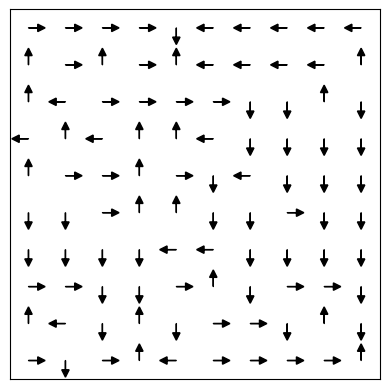

In [57]:
draw_grid(pi_SARSA)

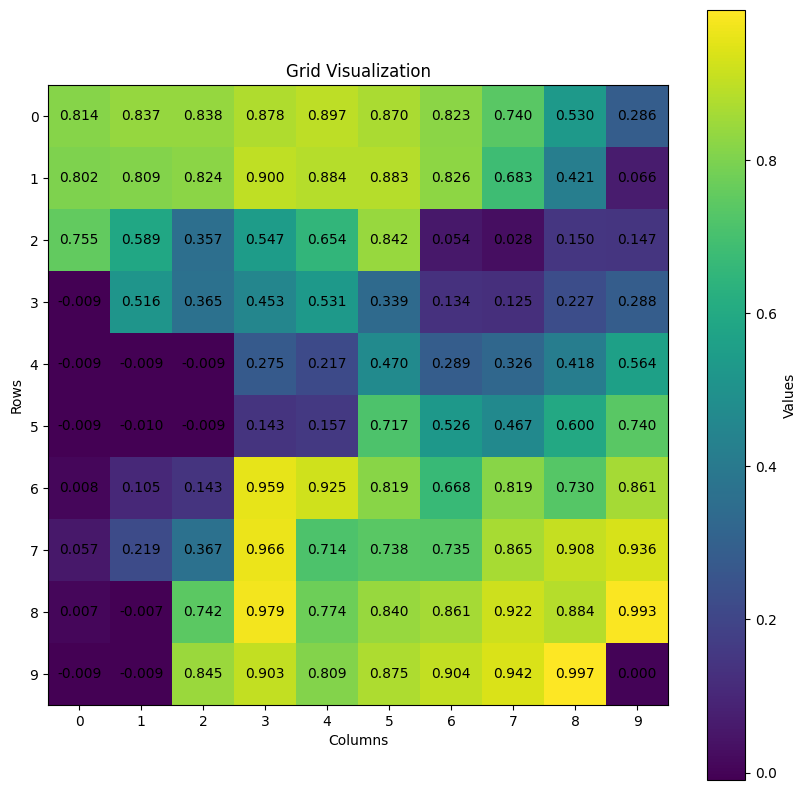

In [58]:
draw_values(V_SARSA)

In [60]:
pi_Q_learning, V_Q_learning = get_pi_v(Q_Q_Learning)

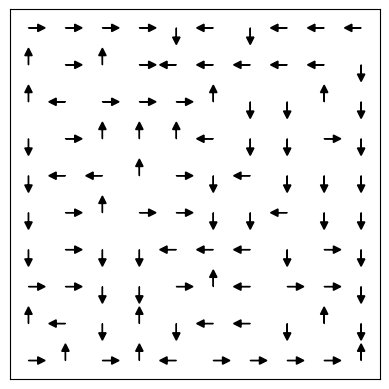

In [61]:
draw_grid(pi_Q_learning)

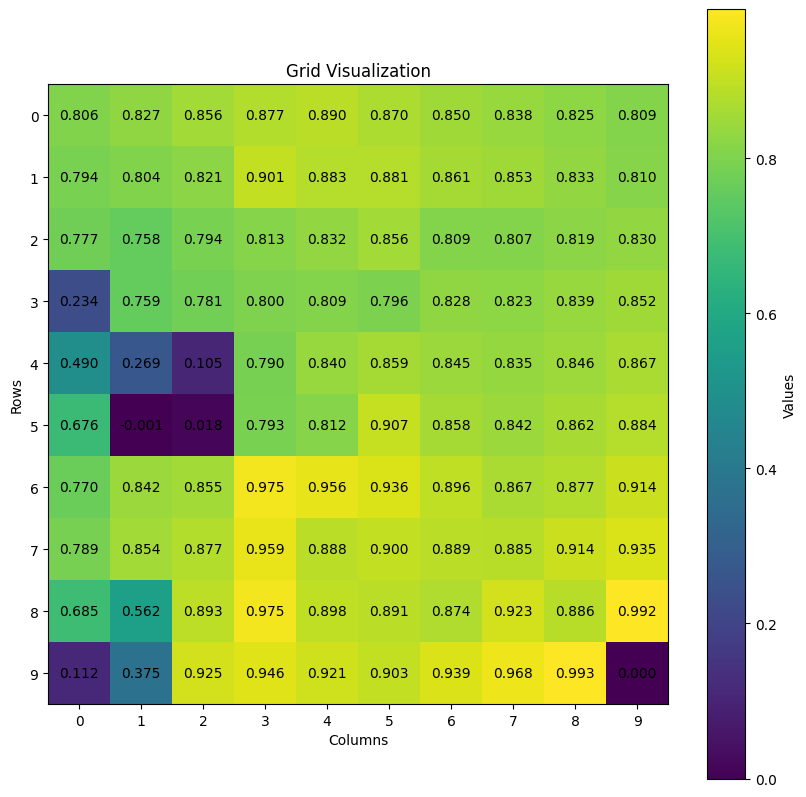

In [62]:
draw_values(V_Q_learning)

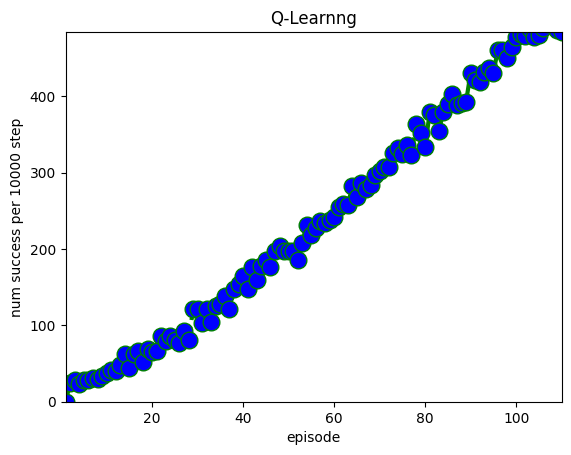

In [63]:
x = [i + 1 for i in range(len(history_Q))] 
y = history_Q
  
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
  
plt.ylim(0,history_Q[-1]) 
plt.xlim(1,len(history_Q)) 
  
plt.xlabel('episode') 
plt.ylabel('num success per 10000 step') 
plt.title('Q-Learnng') 
plt.show() 

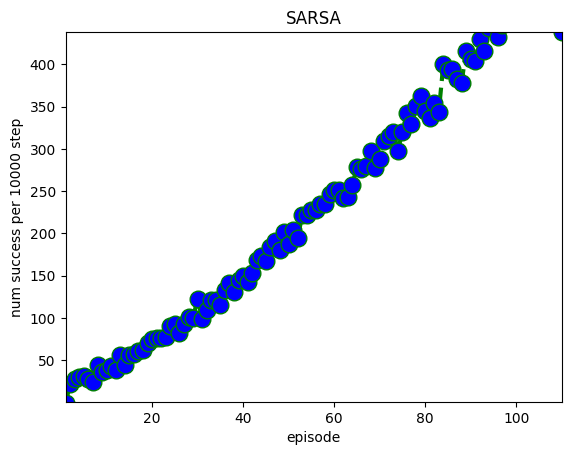

In [64]:
x = [i + 1 for i in range(len(history_SARSA))] 
y = history_SARSA
  
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
  
plt.xlim(1,len(history_SARSA)) 
plt.ylim(1,history_SARSA[-1]) 
  
plt.xlabel('episode') 
plt.ylabel('num success per 10000 step') 
plt.title('SARSA') 
plt.show() 